# Voxel-to-voxel correlation maps
### This notebook is used to perform correlation-based parcellation

## <font color=009DD2> <span style="background-color: #A9C4C0"> Imports

In [1]:
import sys,json
import glob, os
import numpy as np
sys.path.append('/media/miplab-nas2/Data3/BMPD/hc_project/analysis/code/')

from seed_to_voxels import Seed2voxels
from fc_based_parcellation import FC_Parcellation

%matplotlib inline
%load_ext autoreload
%autoreload 2

## <font color=009DD2> <span style="background-color: #A9C4C0"> Initialization

### <font color=009DD2> I Configuration & parameters </font>

In [2]:
with open('../config/config_NK.json') as config_file:
    config = json.load(config_file) # load config file

# Parameters (maybe we should move them to config?)
signal='raw'
seed_names=['C3','C4','C5','C6','C7'] # Define seed names
seed_structure='spinalcord' # Define structure in which seeds are defined (brain or spinal cord)
target_structure='brain' # Define structure to use as target (brain or spinal cord)
ktot = 9
seed_folder = '/scbr_spinalcord_icas_k' + str(ktot) + '/' # Name of folder containing seed tcs, etc.

### <font color=009DD2> II Select files </font>

In [3]:
# /!\ Important notes: 
# Different from ai-based correlation analyses, no _ai suffix appended here for the timeseries txt files

# One target per subject
# We use the unsmoothed data in template space (smoothing can be applied during time courses extraction if needed)
data_target=[];ts_target_txt=[]
for subject_name in config['list_subjects']:
    data_target.append(config['coreg_dir'] + '/sub-' + subject_name + '/' + target_structure + '/sub-' + subject_name + '_task-rest_bold_stc_' + target_structure + '_' + config['coreg_tag'][target_structure] + '.nii')
    ts_target_txt.append(config['main_dir'] + config['seed2vox_dir'] + '/' + target_structure +'_all/timeseries/sub-' + subject_name + '_' + target_structure + '_all_timeseries')
mask_target=config['main_dir'] + config['masks'][target_structure]

# Create directories if needed
if not os.path.exists(config['main_dir'] + config['seed2vox_dir'] + '/' + target_structure + '_all/timeseries/'):
    os.mkdir(config['main_dir'] + config['seed2vox_dir'] + '/' + target_structure + '_all')
    os.mkdir(config['main_dir'] + config['seed2vox_dir'] + '/' + target_structure + '_all/timeseries/') # folder to store timeseries extraction
    
# But possible to have multiple seeds (so create a dictionary to store list of each seed)
data_seed={}; ts_seed_txt={}; mask_seed={}
for seed_name in seed_names:
    data_seed[seed_name] = []
    ts_seed_txt[seed_name] = []
    
    # Create directory for seed if it doesn't exist
    if not os.path.exists(config['main_dir'] + config['seed2vox_dir'] + seed_folder):
        os.mkdir(config['main_dir'] + config['seed2vox_dir'] + seed_folder) 
    if not os.path.exists(config['main_dir'] + config['seed2vox_dir'] + seed_folder + seed_name):
        os.mkdir(config['main_dir'] + config['seed2vox_dir'] + seed_folder + seed_name)

    # For ICA-based seeds
    # We take the binarized ICs (here, matched to individual spinal elvels)
    mask_seed[seed_name] = glob.glob(config['main_dir'] + config['data']['ICA']['spinalcord_dir'] + 'K_' + str(ktot) + '/' + 'comp_bin/' + config['data']['ICA']['tag_filename'] + '*' + seed_name + '*.gz')[0]
    for subject_name in config['list_subjects']:
        data_seed[seed_name].append(config['coreg_dir'] + 'sub-'+ subject_name + '/' + seed_structure + '/sub-' + subject_name + '_task-rest_bold_stc_sc_' + config['coreg_tag'][seed_structure] + '.nii')
        
        # Here, spinal cord is going to be smoothed, hence the tag _s3x3x6 to avoid confusion
        ts_seed_txt[seed_name].append(config['main_dir'] + config['seed2vox_dir'] + seed_folder + seed_name+'/timeseries/sub-' + subject_name + '_' + seed_name + '_timeseries_s3x3x6')
    
    # Create folder for timeseries
    if not os.path.exists(config['main_dir'] + config['seed2vox_dir'] + seed_folder + seed_name + '/timeseries/'):
        os.mkdir(config['main_dir'] + config['seed2vox_dir'] + seed_folder + seed_name + '/timeseries/')
    
    # Create folder for connectivity-based parcellation
    if not os.path.exists(config['main_dir'] + config['seed2vox_dir'] + seed_folder + seed_name + '/cbp/'):
        os.mkdir(config['main_dir'] + config['seed2vox_dir'] + seed_folder + seed_name + '/cbp/')



### <font color=009DD2> III Initialize class based on this </font>

In [ ]:
seed2voxels=Seed2voxels(config,signal,seed_names,target_structure) # initialize the function

## <font color=009DD2> <span style="background-color: #A9C4C0"> Data extraction


### <font color=009DD2> I. Time series extraction - Seed </font>

In [ ]:
# Dictionary with seed names
# Contains one array per subject

# !! Here, smooth seed with 3x3x6 kernel

seed_timeseries={};seed_timeseries_mean={};seed_timeseries_pc1={};
for seed_name in seed_names:
    seed_timeseries[seed_name]=[]
    seed_timeseries_mean[seed_name]=[]
    seed_timeseries_pc1[seed_name]=[]
    (seed_timeseries[seed_name],seed_timeseries_mean[seed_name],seed_timeseries_pc1[seed_name])=seed2voxels.extract_data(img=data_seed[seed_name], smoothing_fwhm=[3,3,6], mask=mask_seed[seed_name],timeseries_txt=ts_seed_txt[seed_name],run="extract",n_jobs=8) # Load or extract timecourses in seed

### <font color=009DD2> II. Time series extraction - Target </font>

In [ ]:
(target_timeseries,target_timeseries_mean,target_timeseries_pc1)=seed2voxels.extract_data(img=data_target, smoothing_fwhm=[6,6,6], mask=mask_target, timeseries_txt=ts_target_txt,
                run="extract",n_jobs=8) # Load voxelwise brain signals as target

## <font color=009DD2> <span style="background-color: #A9C4C0"> Correlation analysis voxelwise

In [ ]:
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm

output_img={};
for seed_name in seed_names: # For each seed
    output_img[seed_name]=[]
    seed = np.array(seed_timeseries[seed_name])
    # Compute in parallel for all voxels
    output_img[seed_name] = Parallel(n_jobs=8)(delayed(seed2voxels.correlation_maps)(seed[:,:,voxel],target_timeseries,mask=mask_target,output_img=None,Fisher=True,save_maps=False,n_jobs=8)
                                               for voxel in tqdm(range(seed.shape[2])))
    # Save seed results as .npy
    np.save(config['main_dir'] + config['seed2vox_dir'] + seed_folder + seed_name + '/cbp' + '/allsub_' + seed_name + '_voxels2' + target_structure + 'brain+sc_smoothed',np.array(output_img[seed_name]))
               

In [ ]:
import numpy as np
from tqdm.notebook import tqdm, trange
import time

output_img={};
for seed_name in seed_names: # For each seed
    output_img[seed_name]=[]
    seed = np.array(seed_timeseries[seed_name])
    # Loop through voxels
    p_bar = tqdm(range(seed.shape[2]))
    for voxel in range(seed.shape[2]):
        p_bar.set_description(f'Voxel {voxel} out of {seed.shape[2]}')
        seed_voxel = seed[:,:,voxel]
        output_img[seed_name].append(seed2voxels.correlation_maps(seed_voxel,target_timeseries,mask=mask_target,output_img=None,Fisher=True,save_maps=False,n_jobs=8))
    # Save seed results as .npy
    np.save(config['main_dir'] + config['seed2vox_dir'] + seed_folder + seed_name + '/cbp' + '/allsub_' + seed_name + '_voxels2' + target_structure + 'brain+sc_smoothed',np.array(output_img[seed_name]))
               

## <font color=009DD2> <span style="background-color: #A9C4C0"> FC-based parcellation

### <font color=009DD2> Method 1: https://www.jneurosci.org/content/32/18/6240 </font>
<font color=009DD2> **Since this method is based on averaging maps from a single voxel in spine, use smoothing in brain + spine** </font>

In [20]:
connectivity = np.load(config['main_dir'] + config['seed2vox_dir'] + seed_folder +'/C6/' + 'cbp/allsub_C6_voxels2brainbrain+sc_smoothed.npy')

In [21]:
kmeans_params = {
     "init": "k-means++",
     "n_init": 100,
     "max_iter": 300,
     }

In [22]:
FCP = FC_Parcellation(config,connectivity,seed_folder,mask_seed['C6'],'C6',mask_target, kmeans_params )

DEFINE NUMBER OF CLUSTERS
...Loading k-means parameters
...Computing SSE and silhouette coefficients
......K = 2
......K = 3
......K = 4
......K = 5
......K = 6
......K = 7
......K = 8
......K = 9
DONE


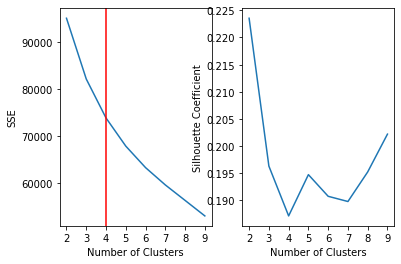

In [23]:
FCP.define_n_clusters(range(2,10))

In [27]:
FCP.run_clustering(5)

RUN K-MEANS CLUSTERING FOR K = 5
DONE


In [28]:
FCP.prepare_brain_maps()

PREPARE BRAIN MAPS
...Compute mean connectivity profiles
...Save as nifti files
DONE


In [29]:
FCP.prepare_seed_map()

PREPARE SEED MAP
DONE
